# Classifying Tweets 

---
Name : Darryn Johnson 

Date : 10/15/2024

Instructor : Mark Barbour 

Blog : 

Studen Pace : FLEX

---
## Sources and Links
- Origional Dataset : [Brands and Products Emotions](https://data.world/crowdflower/brands-and-product-emotions)
- `CHRISP-DM` explination and image : [IBM](https://www.ibm.com/docs/en/spss-modeler/saas?topic=dm-crisp-help-overview)

---
# Overview

- title
- overview
   - import necessary libraries
   - download `nltk wordnet`
   - assign data to variable `df`
- business understanding
    - process
    - business objectives
- data understanding
    - data properties
- data preperation
- methodoligy
    - `CHRISP-DM`
- exploritory data analysis
- model preperation
- model building and analysis
- conclusion
- summary
- index
---

In [144]:
import pandas as pd
import numpy as np
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
confusion_matrix, ConfusionMatrixDisplay,
precision_score, recall_score, 
accuracy_score, f1_score)
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

In [2]:
# this cell only needs to be ran the first time wordnet is used
#nltk.download('wordnet')

In [3]:
df = pd.read_csv('tweet_sentiment_records.csv', encoding = 'latin-1')

---
# Business Undersanding 

The purpose of the following notebook is so a corporation (Google or Apple in this case) can categorize and evaluate customer sentiment of their products. Using Natural Language Processing (NLP), we can do so through stratigies such as `vectorizing`, `lemmatizing`, and modeling using `MultinomialNB`. The purpose of these strategies will be explained later in the notebook as they show up, but the overal idea using these libraries is to :

- lemmatize
    - reduce words to their base form.
      - example : faster -> fast
- vectorize
    - turn words into numbers so the model can understand it
- model
    - utilizing `MultinomialNB`, a library that models the given data for us

---
- Business Objectives
    - classify tweets based on sentiment
        - success includes correctly classifying a majority of tweets
- Situation Assesment
    - resources available
        - data frame containing tweet context as well as who its directed too and the overall sentiment of the tweet
    - resources unavailable
        - data on who the actual tweet is from
- Data mining goals
    - asses and unserstand the data provided
- project plan
    - produce a usable and reliable classification model given the accessable informationble informationble informationble information

---
## Data Understanding 

- Data Properties :
    - the original dataset contains 9093 rows, with each row representing a tweet
    - the original dataset contains 3 columns, with the columns being :
        - tweet_text
        - emotion_in_tweet_is_directed_at
        - is_there_an_emotion_directed_at_a_brand_or_product
            - all 3 of these columns will have their names changed due to how long they are

In [4]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
df = df.rename(columns = {'tweet_text' : 'tweet', 
                          'emotion_in_tweet_is_directed_at': 'directed_to', 
                          'is_there_an_emotion_directed_at_a_brand_or_product' : 'emotion'})

In [6]:
df.head()

,tweet,directed_to,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [7]:
df['tweet'][4]

"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"

In [8]:
df.shape

(9093, 3)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        9092 non-null   object
 1   directed_to  3291 non-null   object
 2   emotion      9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


# Data Preparation

In [10]:
df['emotion'].value_counts()

emotion
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

In [11]:
df[df['emotion'] == "I can't tell"]

,tweet,directed_to,emotion
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell
237,Just what America needs. RT @mention Google to...,NaN,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,NaN,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,NaN,I can't tell
...,...,...,...
9020,It's funny watching a room full of people hold...,NaN,I can't tell
9032,"@mention yeah, we have @mention , Google has n...",NaN,I can't tell
9037,"@mention Yes, the Google presentation was not ...",NaN,I can't tell
9058,&quot;Do you know what Apple is really good at...,NaN,I can't tell


In [12]:
df['emotion'] = df['emotion'].replace({"I can't tell" : 'unk',
                                       "No emotion toward brand or product" : "neutral",
                                      'Positive emotion' : 'positive',
                                      'Negative emotion' : 'negative'}) 

In [13]:
df['emotion'].value_counts()

emotion
neutral     5389
positive    2978
negative     570
unk          156
Name: count, dtype: int64

## Methodoligy

A common methodology used when attempting to create a model is CRISP-DM, which stands for:

- `CR`oss
- `I`ndustry
- `S`tandard
- `P`rocess
- (for)
- `D`ata
- `M`ining

A good visual for how this works is a model designed by [IBM](https://www.ibm.com/docs/en/spss-modeler/saas?topic=dm-crisp-help-overview)

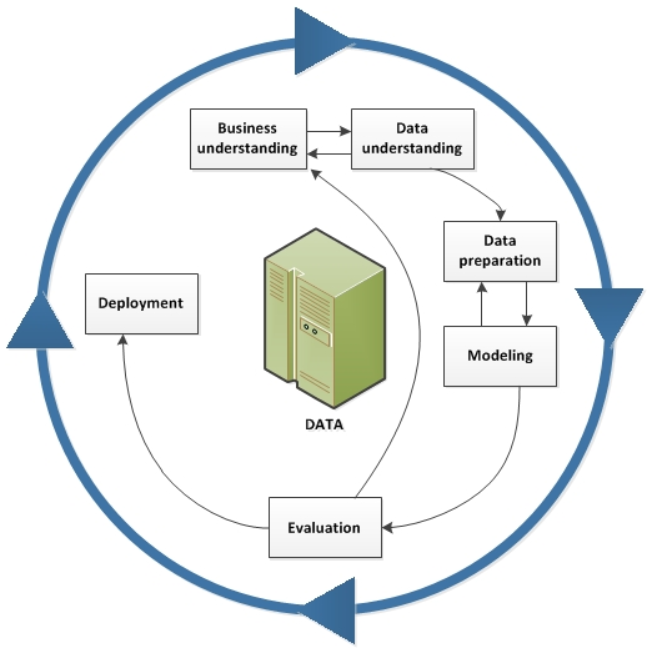

This methodolgy is an overarhcing workflow style, where upon completing a step in the cycle, the next step is started and so on. Where this model really helps though is that its not linear, meaning if needed, returning to a previous step can assist with assuring a thorough and complete modeling process.

# Exploritory Data Analysis

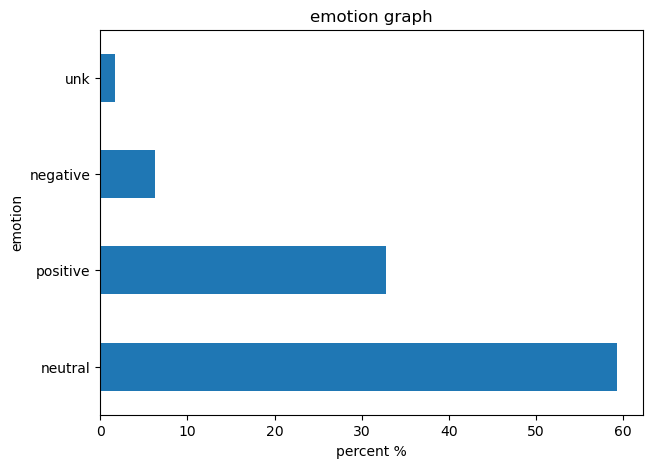

In [14]:
fig, ax = plt.subplots(figsize = (7,5)) # create figure
emotion_bar = df['emotion'].value_counts(normalize=True) * 100 # assign what values to count
emotion_bar.plot(kind='barh') # type of graph
ax.set_xlabel('percent %') # label y axis
ax.set_title('emotion graph') # title
plt.show(); # output

In [15]:
df['directed_to'].value_counts()

directed_to
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

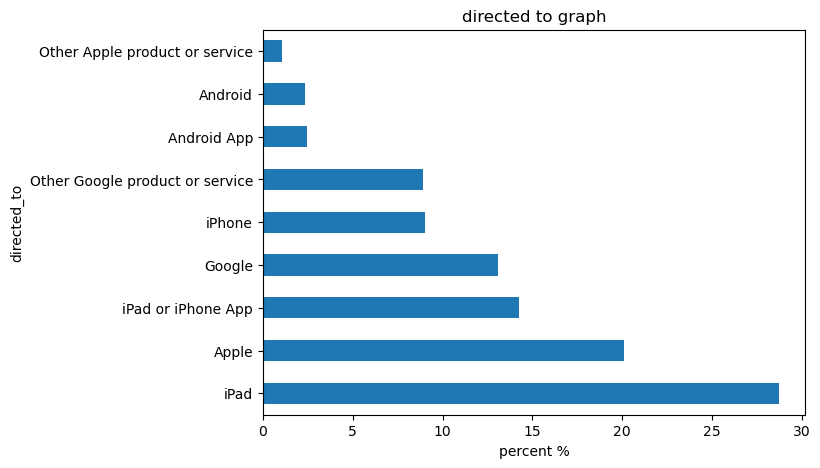

In [16]:
fig, ax = plt.subplots(figsize = (7,5)) # create figure
direction_bar = df['directed_to'].value_counts(normalize=True) * 100 # assign what values to count
direction_bar.plot(kind='barh') # type of graph
ax.set_xlabel('percent %') # label y axis
ax.set_title('directed to graph') # title
plt.show(); # output

In [17]:
df['tweet'][0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [18]:
len(df['tweet'][0].split())

23

In [19]:
df.loc[6]

tweet              NaN
directed_to        NaN
emotion        neutral
Name: 6, dtype: object

In [20]:
df['tweet'].isna().value_counts()

tweet
False    9092
True        1
Name: count, dtype: int64

In [21]:
df = df.drop(6, axis = 0)

In [22]:
def word_count(row):
    return len(str(row).split())

In [23]:
df['word_count'] = df['tweet'].apply(word_count)

In [24]:
df.head()

,tweet,directed_to,emotion,word_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,23
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,22
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,15
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,15
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,17


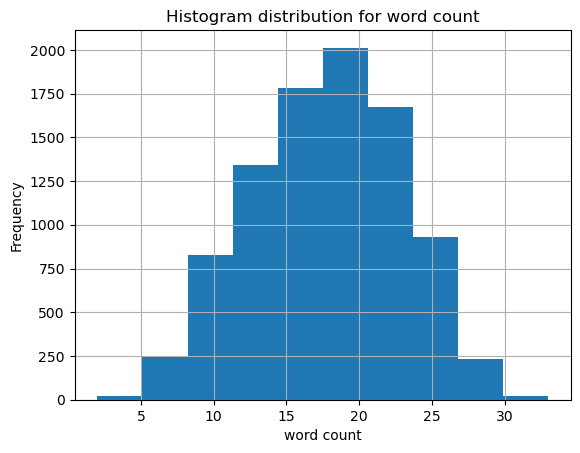

In [25]:
hist = df['word_count'].hist(bins = 10)
plt.title('Histogram distribution for word count') 
plt.xlabel('word count') 
plt.ylabel('Frequency')
plt.show();

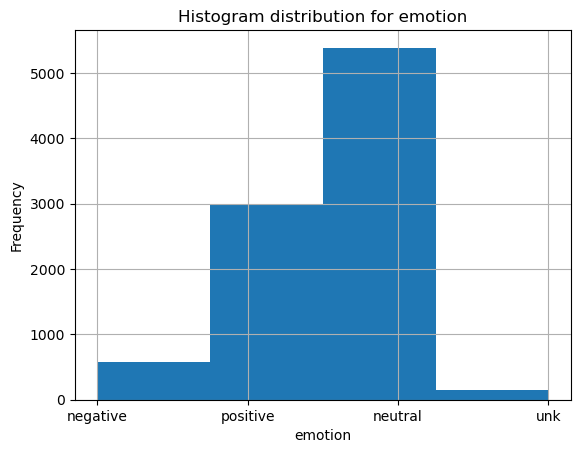

In [26]:
hist = df['emotion'].hist(bins = 4)
plt.title('Histogram distribution for emotion') 
plt.xlabel('emotion') 
plt.ylabel('Frequency')
plt.show();

In [27]:
def avg_word_count_per_emotion(emotion):
    em = emotion
    df_ = df[df['emotion'] == emotion]
    total = len(df_['word_count'])
    count = sum(df_['word_count'])
    avg = round(count / total)
    return (f'{emotion} emotion tweets have a total of {total} words, with an avg of {avg} words per tweet')

In [28]:
avg_word_count_per_emotion('negative')

'negative emotion tweets have a total of 570 words, with an avg of 19 words per tweet'

In [29]:
avg_word_count_per_emotion('positive')

'positive emotion tweets have a total of 2978 words, with an avg of 18 words per tweet'

In [30]:
avg_word_count_per_emotion('neutral')

'neutral emotion tweets have a total of 5388 words, with an avg of 17 words per tweet'

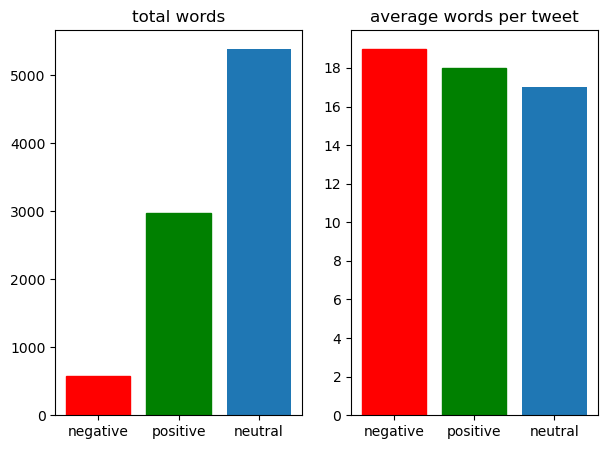

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (7,5))

lables_0 = ['negative', 'positive', 'neutral'] 
bar_0 = ax[0].bar(x = range(3),height = [570, 2978, 5388], tick_label = lables_0)
ax[0].set_title('total words')
bar_0[0].set_color('r')
bar_0[1].set_color('g')

labels_1 = ['negative', 'positive', 'neutral']
bar_1 = ax[1].bar(x = range(3), height = [19, 18, 17], tick_label = labels_1)
ax[1].set_title('average words per tweet')
plt.locator_params(axis = 'y', nbins = 10)
bar_1[0].set_color('r')
bar_1[1].set_color('g')
plt.show();

# Model Preperation

In [32]:
df = df[df['emotion'] != 'unk']

In [33]:
df['emotion'].value_counts()

emotion
neutral     5388
positive    2978
negative     570
Name: count, dtype: int64

In [34]:
df['tweet'][0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [35]:
stopwords_list = stopwords.words('english')

In [36]:
stopwords_list += list(string.punctuation)

In [37]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [38]:
df['tweet'] = df['tweet'].str.lower()

In [39]:
token_test = word_tokenize(df['tweet'][0])

In [40]:
stopped_words_test = [w.lower() for w in token_test if w not in stopwords_list]
stopped_words_test

['wesley83',
 '3g',
 'iphone',
 '3',
 'hrs',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw']

In [41]:
df.head()

,tweet,directed_to,emotion,word_count
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,negative,23
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,positive,22
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,positive,15
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,negative,15
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,positive,17


In [42]:
tweet_example = df['tweet'][0]
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)
tokenizer.tokenize(tweet_example)

['wesley83',
 'have',
 '3g',
 'iphone',
 'after',
 'hrs',
 'tweeting',
 'at',
 'rise_austin',
 'it',
 'was',
 'dead',
 'need',
 'to',
 'upgrade',
 'plugin',
 'stations',
 'at',
 'sxsw']

In [43]:
df['tweet'][0].split()

['.@wesley83',
 'i',
 'have',
 'a',
 '3g',
 'iphone.',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#rise_austin,',
 'it',
 'was',
 'dead!',
 'i',
 'need',
 'to',
 'upgrade.',
 'plugin',
 'stations',
 'at',
 '#sxsw.']

In [44]:
token_list = df['tweet'].apply(tokenizer.tokenize)

In [45]:
token_list

0       [wesley83, have, 3g, iphone, after, hrs, tweet...
1       [jessedee, know, about, fludapp, awesome, ipad...
2       [swonderlin, can, not, wait, for, ipad, also, ...
3       [sxsw, hope, this, year, festival, isn, as, cr...
4       [sxtxstate, great, stuff, on, fri, sxsw, maris...
                              ...                        
9088                       [ipad, everywhere, sxsw, link]
9089    [wave, buzz, rt, mention, we, interrupt, your,...
9090    [google, zeiger, physician, never, reported, p...
9091    [some, verizon, iphone, customers, complained,...
9092    [ïà, ü_, ââ, â_, ûârt, mention, google, tests,...
Name: tweet, Length: 8936, dtype: object

In [46]:
def remove_stopwords(token_list):
    stopwords_removed = [w for w in token_list if w not in stopwords_list]
    return stopwords_removed

In [47]:
df['stopwords_removed'] = token_list.apply(remove_stopwords)

In [48]:
df['stopwords_removed'][0]

['wesley83',
 '3g',
 'iphone',
 'hrs',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw']

In [49]:
df.head()

,tweet,directed_to,emotion,word_count,stopwords_removed
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,negative,23,"[wesley83, 3g, iphone, hrs, tweeting, rise_aus..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,positive,22,"[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,positive,15,"[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,negative,15,"[sxsw, hope, year, festival, crashy, year, iph..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,positive,17,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


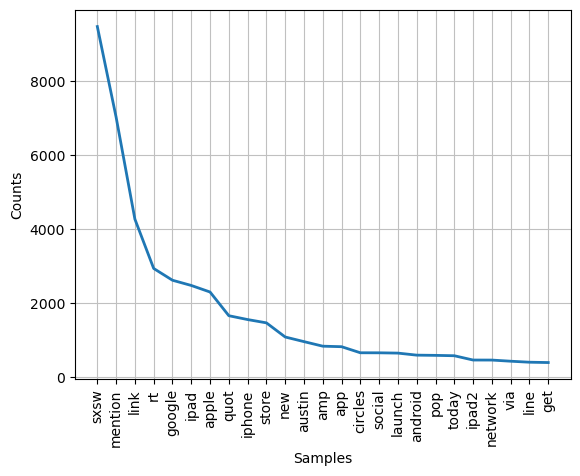

In [50]:
fdist = FreqDist(df['stopwords_removed'].explode())
fdist.plot(25)
plt.show();

# Vectorization & Lemmatization

In [51]:
lem = WordNetLemmatizer()

In [52]:
lem.lemmatize('feet')

'foot'

In [53]:
def lem_col(col):
    return [lem.lemmatize(w) for w in col]

In [54]:
df['text_lemmatized'] = df['stopwords_removed'].apply(lem_col)

In [55]:
df['text_lemmatized'][0]

['wesley83',
 '3g',
 'iphone',
 'hr',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station',
 'sxsw']

In [56]:
df['stopwords_removed'][0]

['wesley83',
 '3g',
 'iphone',
 'hrs',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw']

In [57]:
df.head()

,tweet,directed_to,emotion,word_count,stopwords_removed,text_lemmatized
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,negative,23,"[wesley83, 3g, iphone, hrs, tweeting, rise_aus...","[wesley83, 3g, iphone, hr, tweeting, rise_aust..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,positive,22,"[jessedee, know, fludapp, awesome, ipad, iphon...","[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,positive,15,"[swonderlin, wait, ipad, also, sale, sxsw]","[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,negative,15,"[sxsw, hope, year, festival, crashy, year, iph...","[sxsw, hope, year, festival, crashy, year, iph..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,positive,17,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...","[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


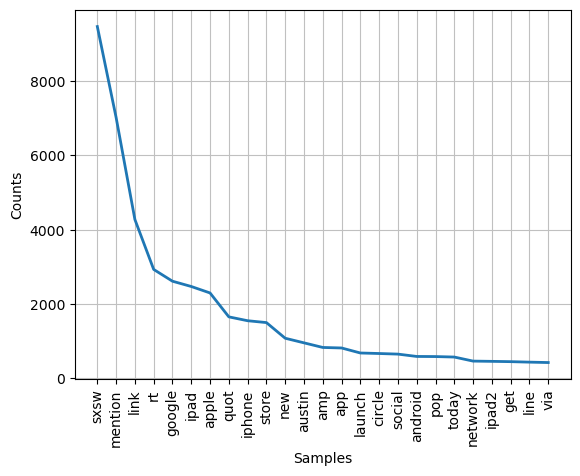

In [58]:
fdist = FreqDist(df['text_lemmatized'].explode())
fdist.plot(25)
plt.show();

## Count Vectorizer

In [59]:
vec = CountVectorizer(lowercase = False)

In [60]:
flat_df = [' '.join(doc) for doc in df['text_lemmatized']]

In [61]:
vec1 = vec.fit_transform(flat_df)

In [62]:
df_vectorized = pd.DataFrame(vec1.toarray(), columns = vec.get_feature_names_out())

In [63]:
df_vectorized.head()

,00,000,00am,00pm,01am,02,03,0310apple,06,08,...,ûò,ûòand,ûó,ûócan,ûójust,ûólewis,ûólots,ûómy,ûóthe,ü_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## tfidf vectorizer

In [64]:
tf = TfidfVectorizer(lowercase = False)

In [65]:
flat_df_tf = [' '.join(doc) for doc in df['text_lemmatized']]

In [66]:
tf_vector = tf.fit_transform(flat_df_tf)

In [67]:
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tf_vector, columns = tf.get_feature_names_out())

In [68]:
tfidf_df.head()

,00,000,00am,00pm,01am,02,03,0310apple,06,08,...,ûò,ûòand,ûó,ûócan,ûójust,ûólewis,ûólots,ûómy,ûóthe,ü_
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modeling

In [69]:
seed = 13
y = df['emotion']
x = df.drop('emotion', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = seed)
sw = stopwords_list

In [70]:
tf_1 = TfidfVectorizer(lowercase = False, max_features = 100)

In [71]:
flat_df_tf_xt = [' '.join(doc) for doc in x_train['text_lemmatized']]

In [72]:
flat_df_tf_xt[0 : 10]

['find sxswi info get free android phone mention sxsw',
 'rt mention sxsw come hear speak 40 min designing ipad interface new navigation schema ballrm 11 00am uxdes mention',
 'rt mention apple open temporary store sxsw 6th congress link atx',
 'ûï mention google launch major new social network called circle possibly today link sxsw mention bigger gaga',
 'free sxsw fluffertrax radio iphone app link',
 'watched quot ipad design headache quot sxsw button hack tapworthy',
 'head link 1pm cst today win vip access acoustic solo set sxsw tonight nokiaconnects',
 'rt mention yayrt mention new ubersocial iphone app store includes uberguide sxsw sponsored mashable link',
 'airport delay sxsw introduced mention catphysics feel like drug pusher first ipad play free',
 'google launch social network quot circle quot denies launch sxsw though link google circle']

In [73]:
tf_vector_xt = tf_1.fit_transform(flat_df_tf_xt)

In [74]:
baseline_model = MultinomialNB()

In [75]:
baseline_cv = cross_val_score(baseline_model, tf_vector_xt, y_train)

In [76]:
baseline_cv

array([0.6256525 , 0.6316182 , 0.6238806 , 0.6380597 , 0.62686567])

In [77]:
baseline_model.fit(tf_vector_xt, y_train)

MultinomialNB()

In [78]:
pred_1 = baseline_model.predict(tf_vector_xt)

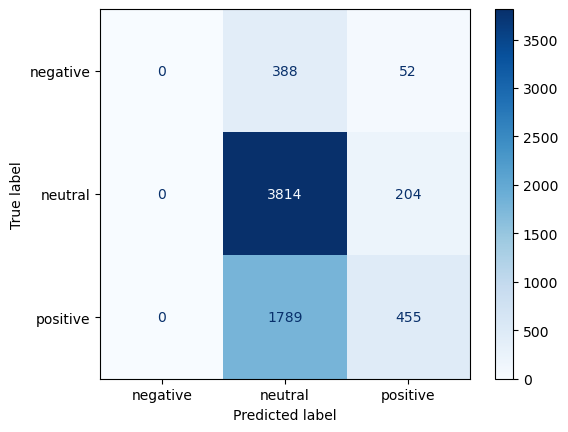

In [79]:
cnf_matrix = confusion_matrix(y_train, pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=baseline_model.classes_)
disp.plot(cmap=plt.cm.Blues)

In [80]:
def get_metrics(y_train, pred):
    acc = accuracy_score(y_train, pred)
    prec = precision_score(y_train, pred, average = 'macro', zero_division = np.nan)
    rec = recall_score(y_train, pred, average = 'macro')
    f1 = f1_score(y_train, pred, average = 'macro')
    print('accuracy:', acc)
    print('precision:', prec)
    print('recall:', rec)
    print('f1 score:', f1)

In [81]:
get_metrics(y_train, pred_1)

accuracy: 0.6369740376007162
precision: 0.6382826701374142
recall: 0.3839971317425714
f1 score: 0.35668890666195124


## smote
to solve the no neg on confusion matrix

In [82]:
sm = SMOTE(random_state = seed)

In [83]:
x_smote, y_smote = sm.fit_resample(tf_vector_xt, y_train)

In [84]:
y_smote.value_counts()

emotion
neutral     4018
positive    4018
negative    4018
Name: count, dtype: int64

In [85]:
y_train.value_counts()

emotion
neutral     4018
positive    2244
negative     440
Name: count, dtype: int64

In [86]:
baseline_model_smote = MultinomialNB()
baseline_cv_smote = cross_val_score(baseline_model_smote, x_smote, y_smote)

In [87]:
baseline_cv_smote

array([0.54541684, 0.54292825, 0.54749067, 0.53878059, 0.55560166])

In [88]:
baseline_model_smote.fit(x_smote, y_smote)

MultinomialNB()

In [89]:
pred_smote = baseline_model_smote.predict(x_smote)

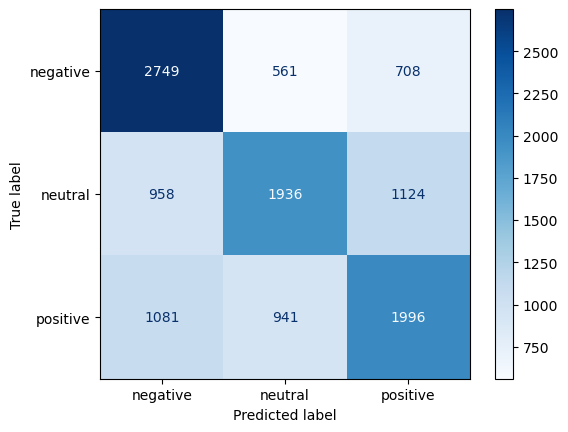

In [90]:
cnf_matrix_smote = confusion_matrix(y_smote, pred_smote)
disp_smote = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_smote, display_labels=baseline_model_smote.classes_)
disp_smote.plot(cmap=plt.cm.Blues)

In [91]:
get_metrics(y_smote, pred_smote)

accuracy: 0.5542558486809358
precision: 0.5528942973688843
recall: 0.5542558486809358
f1 score: 0.5508182103056304


## Smote 2.0

In [92]:
y_train.value_counts()

emotion
neutral     4018
positive    2244
negative     440
Name: count, dtype: int64

In [93]:
samp_strat = {'neutral': 4018, 'positive' : 4018, 'negative' : 880}
sm_2 = SMOTE(random_state = seed, sampling_strategy = samp_strat)

In [94]:
x_smote_2, y_smote_2 = sm_2.fit_resample(tf_vector_xt, y_train)

In [95]:
y_smote_2.value_counts()

emotion
neutral     4018
positive    4018
negative     880
Name: count, dtype: int64

In [96]:
baseline_model_smote_2 = MultinomialNB()
baseline_cv_smote_2 = cross_val_score(baseline_model_smote_2, x_smote_2, y_smote_2)

In [97]:
baseline_cv_smote_2

array([0.57174888, 0.55804823, 0.57936063, 0.57431296, 0.57767807])

In [98]:
baseline_model_smote_2.fit(x_smote_2, y_smote_2)

MultinomialNB()

In [99]:
pred_smote_2 = baseline_model_smote_2.predict(x_smote_2)

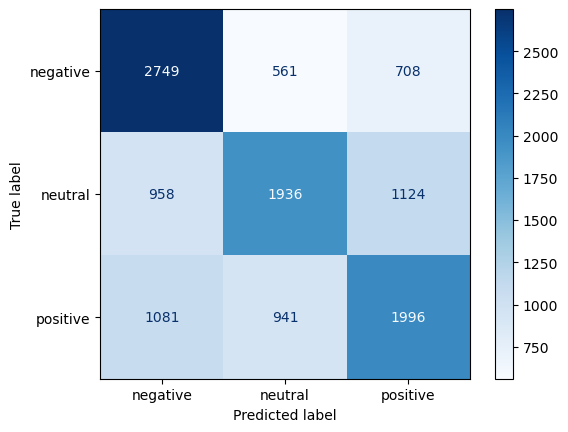

In [100]:
cnf_matrix_smote_2 = confusion_matrix(y_smote_2, pred_smote_2)
disp_smote_2 = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_smote, display_labels=baseline_model_smote_2.classes_)
disp_smote_2.plot(cmap=plt.cm.Blues)

In [101]:
get_metrics(y_smote_2, pred_smote_2)

accuracy: 0.5776132794975325
precision: 0.586626263924899
recall: 0.4281315519555937
f1 score: 0.40678434843061373


## Downsampling

In [102]:
rus = RandomUnderSampler(random_state = seed)

In [103]:
x_undersamp, y_undersamp = rus.fit_resample(tf_vector_xt, y_train)

In [104]:
y_undersamp.value_counts()

emotion
negative    440
neutral     440
positive    440
Name: count, dtype: int64

In [105]:
baseline_model_rus = MultinomialNB()

In [106]:
baseline_cv_rus = cross_val_score(baseline_model_rus, x_undersamp, y_undersamp)

In [107]:
baseline_cv_rus

array([0.49242424, 0.49242424, 0.53030303, 0.46590909, 0.53409091])

In [108]:
baseline_model_rus.fit(x_undersamp, y_undersamp)

MultinomialNB()

In [109]:
pred_rus = baseline_model_rus.predict(x_undersamp)

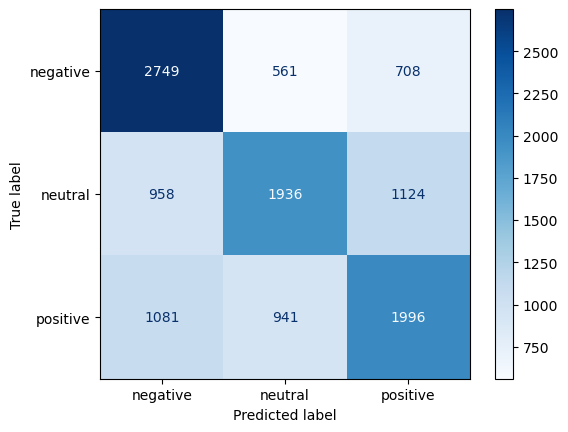

In [110]:
cnf_matrix_rus= confusion_matrix(y_undersamp, pred_rus)
disp_rus = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_rus, display_labels=baseline_model_rus.classes_)
disp_smote_2.plot(cmap=plt.cm.Blues)

In [111]:
get_metrics(y_undersamp, pred_rus)

accuracy: 0.5651515151515152
precision: 0.5670061567333995
recall: 0.5651515151515152
f1 score: 0.5621083930124793


## Random Under Sampler 2.0

In [112]:
y_train.value_counts()

emotion
neutral     4018
positive    2244
negative     440
Name: count, dtype: int64

In [113]:
samp_strat_under = {'neutral' : 2009, 'positive' : 1122, 'negative' : 440}

In [114]:
rus_2 = RandomUnderSampler(random_state = seed, sampling_strategy = samp_strat_under)

In [115]:
x_rus_2, y_rus_2 = rus_2.fit_resample(tf_vector_xt, y_train)

In [116]:
y_rus_2.value_counts()

emotion
neutral     2009
positive    1122
negative     440
Name: count, dtype: int64

In [117]:
baseline_model_rus_2 = MultinomialNB()

In [118]:
baseline_cv_rus = cross_val_score(baseline_model_rus_2, x_rus_2, y_rus_2)

In [119]:
baseline_cv_rus

array([0.59440559, 0.59103641, 0.58403361, 0.60504202, 0.57282913])

In [120]:
baseline_model_rus_2.fit(x_rus_2, y_rus_2)

MultinomialNB()

In [121]:
pred_rus_2 = baseline_model_rus.predict(x_rus_2)

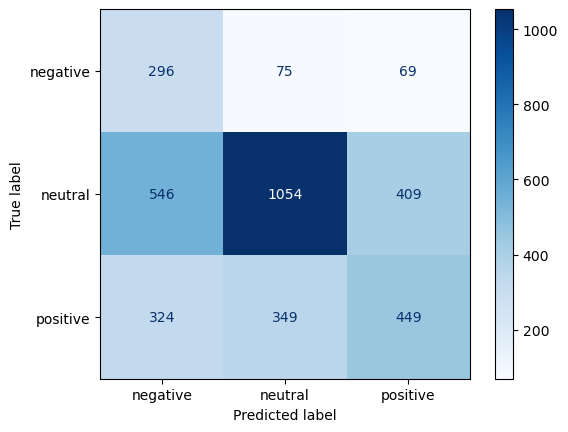

In [122]:
cnf_matrix_rus_2= confusion_matrix(y_rus_2, pred_rus_2)
disp_rus_2 = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_rus_2, display_labels=baseline_model_rus_2.classes_)
disp_rus_2.plot(cmap=plt.cm.Blues)

In [123]:
get_metrics(y_rus_2, pred_rus_2)

accuracy: 0.5037804536544386
precision: 0.483781112829591
recall: 0.5325148832629873
f1 score: 0.4704704554547357


notes :

grid tfidf vec
grid 

In [124]:
y_train.value_counts()

emotion
neutral     4018
positive    2244
negative     440
Name: count, dtype: int64

In [125]:
rus_3 = RandomUnderSampler(random_state = seed)

In [126]:
tfidf = TfidfVectorizer(lowercase = False)

In [127]:
x_under, y_under = rus_3.fit_resample(x_train, y_train)

In [128]:
x_under_flat = [' '.join(doc) for doc in x_under['text_lemmatized']]

In [129]:
pipe = Pipeline([('tf', TfidfVectorizer(lowercase = False)),
                 ('mn' , MultinomialNB())])

params = [{
    'tf__max_features' : (50, 100, 200, 500, 1000, 2000, 3000, 4000)}]

grid = GridSearchCV(pipe, params)

In [130]:
grid.fit(x_under_flat, y_under)

GridSearchCV(estimator=Pipeline(steps=[('tf', TfidfVectorizer(lowercase=False)),
                                       ('mn', MultinomialNB())]),
             param_grid=[{'tf__max_features': (50, 100, 200, 500, 1000, 2000,
                                               3000, 4000)}])

In [131]:
grid.best_params_

{'tf__max_features': 3000}

In [132]:
pipe_2 = Pipeline([('tf', TfidfVectorizer(lowercase = False, max_features = 3000))
                 ,('mn' , MultinomialNB())])

In [133]:
pipe_2.fit(x_under_flat, y_under)

Pipeline(steps=[('tf', TfidfVectorizer(lowercase=False, max_features=3000)),
                ('mn', MultinomialNB())])

In [134]:
pipe_2_pred = pipe_2.predict(x_under_flat)

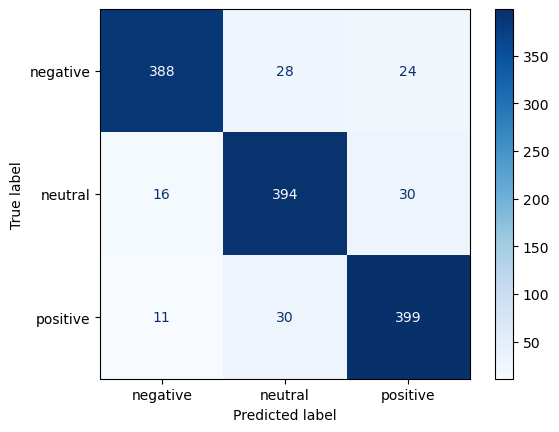

In [135]:
cnf_matrix_pipe_2= confusion_matrix(y_under, pipe_2_pred)
disp_pipe_2 = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_pipe_2, display_labels = pipe_2.classes_)
disp_pipe_2.plot(cmap=plt.cm.Blues)

In [136]:
get_metrics(y_under, pipe_2_pred)

accuracy: 0.8946969696969697
precision: 0.8958052923173677
recall: 0.8946969696969697
f1 score: 0.894875810735587


# The Final Model

In [137]:
x_test_under, y_test_under = rus_3.fit_resample(x_test, y_test)

In [138]:
x_test_under_flat = [' '.join(doc) for doc in x_test_under['text_lemmatized']]

In [139]:
pipe_2.fit(x_test_under_flat, y_test_under)

Pipeline(steps=[('tf', TfidfVectorizer(lowercase=False, max_features=3000)),
                ('mn', MultinomialNB())])

In [140]:
pipe_2_pred_test = pipe_2.predict(x_test_under_flat)

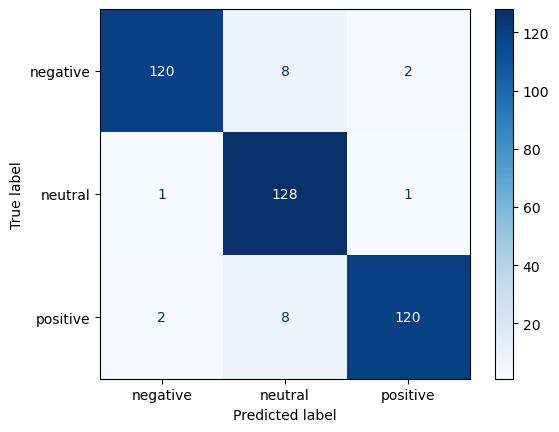

In [141]:
cnf_matrix_pipe_3= confusion_matrix(y_test_under, pipe_2_pred_test)
disp_pipe_2_test = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix_pipe_3, display_labels = pipe_2.classes_)
disp_pipe_2_test.plot(cmap=plt.cm.Blues)

In [142]:
get_metrics(y_test_under, pipe_2_pred_test)

accuracy: 0.9435897435897436
precision: 0.9467028003613369
recall: 0.9435897435897437
f1 score: 0.9438465903080311
